### Imports und Datei

In [1]:
import osmium as osm
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import matplotlib.image as mpimg
from sklearn.cluster import DBSCAN
import numpy as np
import os
import requests
from collections import Counter
from matplotlib.ticker import MaxNLocator
from math import radians, cos, sin, asin, sqrt
import xml.etree.ElementTree as ET

# Setze den Pfad zum Dataset
dataset_path = os.path.join("Datasets", "unterfranken-latest.osm")
city_name = "Ringheim"   

### Alle Daten aus dem Datensatz auslesen

In [2]:
class OSMHandler(osm.SimpleHandler):
    def __init__(self):
        osm.SimpleHandler.__init__(self)
        self.osm_data = []

    def tag_inventory(self, elem, elem_type, lon=None, lat=None, node_ids=None):
        if len(elem.tags) == 0:
            # Für Knoten ohne Tags
            self.osm_data.append([elem_type, 
                                  elem.id, 
                                  elem.visible, 
                                  0, 
                                  None, 
                                  None, 
                                  lon, 
                                  lat, 
                                  node_ids])
        else:
            for tag in elem.tags:
                self.osm_data.append([elem_type, 
                                      elem.id,
                                      elem.visible,
                                      len(elem.tags),
                                      tag.k, 
                                      tag.v, lon, lat, node_ids])

    def node(self, n):
        self.tag_inventory(n, "node", lon=n.location.lon, lat=n.location.lat)

    def way(self, w):
        node_ids = [n.ref for n in w.nodes]  
        self.tag_inventory(w, "way", node_ids=node_ids)

# Daten auslesen
osmhandler = OSMHandler()
osmhandler.apply_file(dataset_path)

# DataFrame erstellen
data_colnames = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids']
df_osm = pd.DataFrame(osmhandler.osm_data, columns=data_colnames)
df_osm

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
0,node,507975,True,10,TMC:cid_58:tabcd_1:Class,Point,9.012274,49.994112,None
1,node,507975,True,10,TMC:cid_58:tabcd_1:Direction,negative,9.012274,49.994112,None
2,node,507975,True,10,TMC:cid_58:tabcd_1:LCLversion,9.00,9.012274,49.994112,None
3,node,507975,True,10,TMC:cid_58:tabcd_1:LocationCode,10863,9.012274,49.994112,None
4,node,507975,True,10,TMC:cid_58:tabcd_1:NextLocationCode,59626,9.012274,49.994112,None
...,...,...,...,...,...,...,...,...,...
14504017,way,1307299066,True,1,landuse,farmland,NaN,NaN,"[12106567512, 12106567511, 12106567510, 121065..."
14504018,way,1307299067,True,1,landuse,meadow,NaN,NaN,"[1258603417, 1258604236, 12106567525, 12106567..."
14504019,way,1307299068,True,1,landuse,meadow,NaN,NaN,"[12106567540, 1258603672, 1258603933, 12106567..."
14504020,way,1307299069,True,1,landuse,meadow,NaN,NaN,"[1258603201, 12106567537, 12106567536, 1258604..."


### Datensatz nach Wegen gefiltert

In [3]:
ways_filter = df_osm[(df_osm['type'] == 'way') & (df_osm['tagkey'] == 'highway')]
ways_filter

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
10879419,way,3665983,True,6,highway,motorway_link,NaN,NaN,"[18177874, 18177875, 18177876, 2145470970, 214..."
10879428,way,3665987,True,14,highway,primary_link,NaN,NaN,"[18177944, 8684650962, 8684650961, 18177945, 2..."
10879441,way,3665989,True,18,highway,primary,NaN,NaN,"[52002528, 7691431851, 3463913709, 298539137]"
10879462,way,3665993,True,24,highway,secondary,NaN,NaN,"[18178013, 610518435, 717818571]"
10879482,way,3665996,True,9,highway,motorway_link,NaN,NaN,"[10799089, 10799091, 11579636997, 11579636996,..."
...,...,...,...,...,...,...,...,...,...
14503812,way,1307134246,True,7,highway,residential,NaN,NaN,"[12105226801, 2773668523]"
14503893,way,1307138944,True,4,highway,residential,NaN,NaN,"[302490951, 9383332898, 4730339428, 4730339402]"
14503966,way,1307138950,True,2,highway,secondary,NaN,NaN,"[11830891345, 11809434805]"
14503983,way,1307141259,True,5,highway,residential,NaN,NaN,"[413711326, 503587053]"


### API-Anfrage für die Längen- und Breitengrade der Städte

In [21]:
# API-Anfrage um Bounding Box der Stadt zu bekommen
def get_bounding_box(city_name):
    url = f"https://nominatim.openstreetmap.org/search?city={city_name}&format=json"
    headers = {
        "User-Agent": "Bachelorproject/1.0"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        results = response.json()
        for result in results:
            if result.get("osm_type") == "relation" and 'boundingbox' in result:
                bbox = result['boundingbox']
                return [float(coord) for coord in bbox]  
    raise ValueError("Bounding Box konnte nicht abgerufen werden.")
    
bbox = get_bounding_box(city_name)
south, north, west, east = bbox

df_filtered_nodes = df_osm[
    ((df_osm['latitude'] >= south) & (df_osm['latitude'] <= north)) &
    ((df_osm['longitude'] >= west) & (df_osm['longitude'] <= east))    
]

df_filtered_nodes

,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
207,node,524031,True,0,None,None,9.067052,49.942992,None
8710,node,27345583,True,0,None,None,9.064143,49.942001,None
8711,node,27345584,True,0,None,None,9.058106,49.939210,None
8712,node,27345585,True,0,None,None,9.056312,49.940232,None
8713,node,27345586,True,0,None,None,9.046306,49.936876,None
...,...,...,...,...,...,...,...,...,...
10827194,node,12049886386,True,1,highway,street_lamp,9.054605,49.938977,None
10827195,node,12049886890,True,2,leaf_type,broadleaved,9.056344,49.940104,None
10827196,node,12049886890,True,2,natural,tree,9.056344,49.940104,None
10827197,node,12049887876,True,1,highway,street_lamp,9.054266,49.939013,None


### Daten in XML-Datei speichern

In [22]:
def save_to_xml(df, city_name):
    # Wurzelelement erstellen
    root = ET.Element("osm", version="0.6", generator="Bachelorproject")
    
    # Knoten hinzufügen
    for _, row in df[df['type'] == 'node'].iterrows():
        node = ET.SubElement(root, "node", id=str(row['id']),
                             visible=str(row['visible']),
                             lat=str(row['latitude']),
                             lon=str(row['longitude']))
        if row['tagkey']:
            ET.SubElement(node, "tag", k=row['tagkey'], v=row['tagvalue'])
    
    # Wege hinzufügen
    for _, row in df[df['type'] == 'way'].iterrows():
        way = ET.SubElement(root, "way", id=str(row['id']), visible=str(row['visible']))
        for node_id in row['node_ids']:
            ET.SubElement(way, "nd", ref=str(node_id))
        if row['tagkey']:
            ET.SubElement(way, "tag", k=row['tagkey'], v=row['tagvalue'])

    # XML-Baum erstellen und speichern
    city_folder = os.path.join("City_data")
    os.makedirs(city_folder, exist_ok=True)
    tree = ET.ElementTree(root)
    file_path = os.path.join(city_folder, f"{city_name}.osm")
    tree.write(file_path, encoding="utf-8", xml_declaration=True)
    print(f"Datei erfolgreich gespeichert: {file_path}")

### Daten aus der XML-Datei lesen

In [23]:
def load_from_xml(city_name):
    file_path = os.path.join("City_data", f"{city_name}.osm")
    tree = ET.parse(file_path)
    root = tree.getroot()

    osm_data = []

    # Knoten extrahieren
    for node in root.findall("node"):
        node_id = int(node.get("id"))
        lon = float(node.get("lon"))
        lat = float(node.get("lat"))
        osm_data.append(["node", node_id, True, 0, None, None, lon, lat, None])

    # Wege extrahieren
    for way in root.findall("way"):
        way_id = int(way.get("id"))
        node_ids = [int(nd.get("ref")) for nd in way.findall("nd")]
        for tag in way.findall("tag"):
            tagkey = tag.get("k")
            tagvalue = tag.get("v")
            osm_data.append(["way", way_id, True, len(way.findall("tag")), tagkey, tagvalue, None, None, node_ids])

    # DataFrame erstellen
    columns = ['type', 'id', 'visible', 'ntags', 'tagkey', 'tagvalue', 'longitude', 'latitude', 'node_ids']
    return pd.DataFrame(osm_data, columns=columns)

### Datensatz nach Städten filtern

In [24]:
ways_filter = ways_filter[ways_filter['node_ids'].apply(lambda node_ids: any(node in df_filtered_nodes['id'].values for node in node_ids))]
df_filtered = pd.concat([df_filtered_nodes, ways_filter])
df_filtered.fillna('')
save_to_xml(df_filtered, city_name)
df_filtered

Datei erfolgreich gespeichert: City_data\Ringheim.osm


,type,id,visible,ntags,tagkey,tagvalue,longitude,latitude,node_ids
207,node,524031,True,0,None,None,9.067052,49.942992,None
8710,node,27345583,True,0,None,None,9.064143,49.942001,None
8711,node,27345584,True,0,None,None,9.058106,49.939210,None
8712,node,27345585,True,0,None,None,9.056312,49.940232,None
8713,node,27345586,True,0,None,None,9.046306,49.936876,None
...,...,...,...,...,...,...,...,...,...
14312770,way,1154590284,True,11,highway,residential,NaN,NaN,"[382205234, 570857299, 570857237, 570857287, 5..."
14324504,way,1168473515,True,3,highway,track,NaN,NaN,"[290985227, 10866933653, 3190521519, 319052148..."
14368481,way,1197048147,True,13,highway,residential,NaN,NaN,"[571948709, 3426707915]"
14368494,way,1197048148,True,12,highway,residential,NaN,NaN,"[3426707915, 248048889, 571948436, 269354314]"


### Haversine-Formel

In [25]:
def haversine(lon1, lat1, lon2, lat2):
    # Dezimalzahlen in Radianten umwandeln
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine Formel
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius der Erde in Kilometer
    return c * r * 1000

### Straßenlänge berechnen 

In [26]:
# Straßenlänge berechnen
def calculate_full_road_length(way_row, df_nodes):
    node_ids = way_row['node_ids']
    total_length = 0

    for i in range(len(node_ids) - 1):
        first_node = df_nodes[df_nodes['id'] == node_ids[i]]
        second_node = df_nodes[df_nodes['id'] == node_ids[i + 1]]

        # Überprüfung, ob beide Knoten existieren
        if first_node.empty or second_node.empty:
            return None

        total_length += haversine(
            first_node['longitude'].values[0], first_node['latitude'].values[0],
            second_node['longitude'].values[0], second_node['latitude'].values[0]
        )

    return total_length

df_city_data = load_from_xml(city_name)
valid_ways = df_city_data[df_city_data['type'] == 'way'].dropna(subset=['node_ids'])

road_lengths = []

for index, way_row in valid_ways.iterrows():
    length = calculate_full_road_length(way_row, df_city_data)
    if length is not None:
        road_lengths.append({'way_id': way_row['id'], 'length': length})

df_road_length = pd.DataFrame(road_lengths)
df_road_length

,way_id,length
0,22568420,79.208183
1,23007686,27.749088
2,23007687,151.848568
3,23007688,392.044903
4,23007689,139.941911
...,...,...
332,1154590284,183.188391
333,1168473515,318.292120
334,1197048147,27.724026
335,1197048148,127.892782


### Kreuzungsknoten erhalten

In [27]:
df_city_data = load_from_xml(city_name)
all_node_ids = []
for node_ids_list in df_city_data[df_city_data['type'] == 'way']['node_ids']:
    if node_ids_list is not None:
        all_node_ids.extend(node_ids_list)

node_reference_count = Counter(all_node_ids)
nodes_referenced_multiple = {node_id for node_id, count in node_reference_count.items() if count > 1}

df_nodes_filtered_multiple = df_city_data[(df_city_data['type'] == 'node') & (df_city_data['id'].isin(nodes_referenced_multiple))]

filtered_data_multiple = pd.concat([df_city_data[df_city_data['type'] == 'way'], df_nodes_filtered_multiple], ignore_index=True)

save_to_xml(filtered_data_multiple, city_name)

Datei erfolgreich gespeichert: City_data\Ringheim.osm


### Graph vor dem Entfernen der Grad-2-Knoten

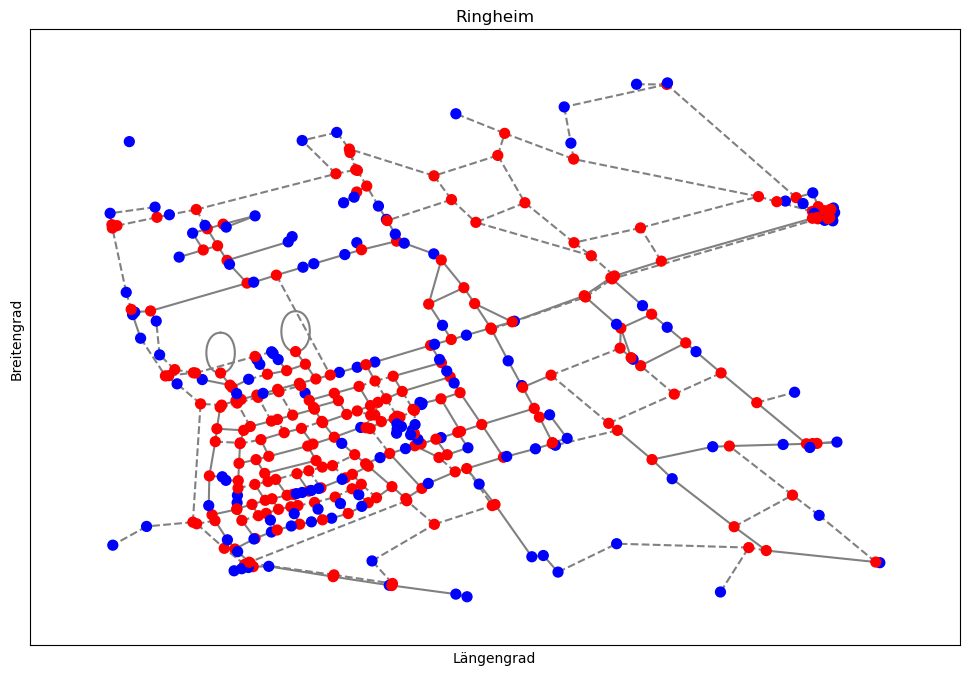

In [28]:
df_city_data = load_from_xml(city_name)

G = nx.Graph()

# Knoten zum Graphen hinzufügen
for index, row in df_city_data[df_city_data['type'] == 'node'].iterrows():  
    G.add_node(row['id'], pos=(row['longitude'], row['latitude']))

# Kanten zum Graphen hinzufügen
for index, way in df_city_data[df_city_data['type'] == 'way'].iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
        if len(filtered_node_ids_list) > 1:
            for i in range(len(filtered_node_ids_list) - 1):
                is_dashed_highway = way['tagkey'] == 'highway' and way['tagvalue'] not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                G.add_edge(
                    filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                    street_name=way['tagvalue'],
                    is_dashed_highway=is_dashed_highway
                )

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(12, 8))

# Normale Kanten zeichnen
edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

# Gestrichelte Kanten zeichnen
edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

node_degrees = dict(G.degree())
node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

plt.title(city_name)
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.show()

### Knoten vom Grad 2 entfernen

#### Funktionen für die Bearbeitung der Grad 2 Knoten

In [13]:
G = nx.Graph()

neighbors_found = {}

# Entfernen von Knoten mit Grad 2 aus den node-ids
def remove_degree_2_nodes(node_ids):
    if node_ids is not None:
        return [node_id for node_id in node_ids if node_id not in degree_2_node_ids]
    return node_ids

# 2 Grad-3+-Nachbarn finden
def find_neighbors_with_degree_3(node_id, visited=None, found_neighbors=None):
    if visited is None:
        visited = set()
    if found_neighbors is None:
        found_neighbors = []

    visited.add(node_id)
    neighbors = list(G.neighbors(node_id))

    for neighbor in neighbors:
        if neighbor not in visited:
            neighbor_degree = G.degree(neighbor)

            # Füge Nachbarn hinzu, wenn er Grad 3 oder höher hat
            if neighbor_degree >= 3:
                found_neighbors.append(neighbor)

                if node_id not in neighbors_found:
                    neighbors_found[node_id] = []
                neighbors_found[node_id].append(neighbor)

                # Stoppe, wenn zwei passende Nachbarn gefunden wurden
                if len(found_neighbors) == 2:
                    return found_neighbors

            # Rekursive Suche fortsetzen, wenn der Nachbar Grad 2 hat
            elif neighbor_degree == 2:
                result = find_neighbors_with_degree_3(neighbor, visited, found_neighbors)
                if len(result) == 2:
                    return result
                
    return found_neighbors

# Aktualisieren der node_ids der Straßen, die Knoten mit Grad 2 enthalten
def update_node_ids(row, degree_2_node_ids):
    node_ids = row['node_ids']
    if node_ids is not None:
        updated_node_ids = list(node_ids)
        for node_id in node_ids:
            if node_id in degree_2_node_ids:
                # Finde Nachbarn des Knotens mit Grad 2
                neighbors = find_neighbors_with_degree_3(node_id)
                if len(neighbors) == 2:
                    neighbor_1, neighbor_2 = neighbors

                    # Finde die zwei Straßen, die den Grad-2-Knoten referenzieren
                    referencing_ways = ways_filter[ways_filter['node_ids'].apply(lambda x: node_id in x)]

                    if len(referencing_ways) == 2:
                        way_1, way_2 = referencing_ways.iloc[0], referencing_ways.iloc[1]

                        # Kopiere die Node-IDs als Listen
                        way_1_node_ids = list(way_1['node_ids']) if isinstance(way_1['node_ids'], list) else way_1['node_ids']
                        way_2_node_ids = list(way_2['node_ids']) if isinstance(way_2['node_ids'], list) else way_2['node_ids']

                        # Füge Nachbarn hinzu, falls sie nicht bereits vorhanden sind
                        if neighbor_1 not in way_2_node_ids:
                            way_2_node_ids.append(neighbor_1)
                        if neighbor_1 not in way_1_node_ids:
                            way_1_node_ids.append(neighbor_1)

                        # Aktualisiere die DataFrame-Zeilen
                        ways_filter.at[way_1.name, 'node_ids'] = way_1_node_ids
                        ways_filter.at[way_2.name, 'node_ids'] = way_2_node_ids

        # Stelle sicher, dass die Rückgabewerte korrekt sind
        return updated_node_ids if updated_node_ids else None
    return node_ids

#### Funktionen für die Bearbeitung der speziellen Grad-2-Knoten

In [14]:
def handle_special_degree_2_nodes(special_nodes, connected_ways, G):
    neighbors_by_special_node = {}

    def find_special_neighbors(node_id, connected_node_ids, visited=None, found_neighbors=None):
        if visited is None:
            visited = set()
        if found_neighbors is None:
            found_neighbors = set()

        visited.add(node_id)
        neighbors = list(G.neighbors(node_id))

        for neighbor in neighbors:
            if neighbor not in visited and neighbor in connected_node_ids:  
                neighbor_degree = G.degree(neighbor)

                # Füge Nachbarn hinzu, wenn er Grad 3 oder höher hat
                if neighbor_degree >= 3:
                    found_neighbors.add(neighbor) 

                    # Stoppe, wenn zwei passende Nachbarn gefunden wurden
                    if len(found_neighbors) == 2:
                        return list(found_neighbors)

                # Rekursive Suche fortsetzen, wenn der Nachbar Grad 2 hat
                elif neighbor_degree == 2:
                    result = find_special_neighbors(neighbor, connected_node_ids, visited, found_neighbors)
                    if len(result) == 2:
                        return list(result)

        return list(found_neighbors)

    # Für jeden speziellen Knoten die Nachbarn durch verbundene Wege finden
    for node_id, ways in connected_ways.items():
        neighbors_by_special_node[node_id] = []
        connected_node_ids = set()
        for way_id in ways:
            way = ways_filter[ways_filter['id'] == way_id]
            if not way.empty:
                connected_node_ids.update(way.iloc[0]['node_ids'])

        # Suche Nachbarn des speziellen Knotens, die Grad 3+ haben und in connected_node_ids liegen
        neighbors = find_special_neighbors(node_id, connected_node_ids)
        if neighbors:
            neighbors_by_special_node[node_id].extend(neighbors)

    return neighbors_by_special_node

# Identifizieren der speziellen Grad-2-Knoten
def identify_special_degree_2_nodes(node_way_mapping):
    special_nodes = {node_id: ways for node_id, ways in node_way_mapping.items() if len(ways) > 2}
    return special_nodes

# Ermitteln der Straßen, die mit speziellen Grad-2-Knoten verbunden sind
def get_connected_ways_for_special_nodes(df_special_nodes, valid_ways, G):
    connected_ways_by_node = {}

    for _, node_row in df_special_nodes.iterrows():
        node_id = node_row['id']
        connected_ways_by_node[node_id] = []
        
        # Finde Wege, die mit diesem speziellen Knoten verbunden sind
        for _, way_row in valid_ways.iterrows():
            way_id = way_row['id']
            node_ids_list = way_row['node_ids']
            
            if node_id in node_ids_list:
                # Prüfen, ob die Knoten des Wegs im Graphen existieren
                for i in range(len(node_ids_list) - 1):
                    u, v = node_ids_list[i], node_ids_list[i + 1]
                    if G.has_edge(u, v):
                        connected_ways_by_node[node_id].append(way_id)
                        break

    return connected_ways_by_node

# Aktualisieren der node_ids für spezielle Knoten
def update_special_node_ids(row, special_nodes, neighbors_by_special_node, connected_ways_for_special_nodes):
    node_ids = row['node_ids']

    if not isinstance(node_ids, list):
        node_ids = []
    
    if node_ids:
        updated_node_ids = list(node_ids)
        
        for node_id in node_ids:
            if node_id in special_nodes:
                neighbors = neighbors_by_special_node.get(node_id, [])
        
                if len(neighbors) == 2:
                    neighbor_1, neighbor_2 = neighbors
                    referencing_ways = connected_ways_for_special_nodes.get(node_id, [])
                    if len(referencing_ways) == 2:
                        way_1_id, way_2_id = referencing_ways[0], referencing_ways[1]
                        
                        way_1 = ways_filter[ways_filter['id'] == way_1_id].iloc[0]
                        way_2 = ways_filter[ways_filter['id'] == way_2_id].iloc[0]

                        way_1_node_ids = list(way_1['node_ids']) if isinstance(way_1['node_ids'], list) else way_1['node_ids']
                        way_2_node_ids = list(way_2['node_ids']) if isinstance(way_2['node_ids'], list) else way_2['node_ids']

                        if neighbor_1 not in way_2_node_ids:
                            way_2_node_ids.append(neighbor_1)
                        if neighbor_1 not in way_1_node_ids:
                            way_1_node_ids.append(neighbor_1)

                        ways_filter.at[way_1.name, 'node_ids'] = way_1_node_ids
                        ways_filter.at[way_2.name, 'node_ids'] = way_2_node_ids
        
        return updated_node_ids if updated_node_ids else None
    
    return node_ids

# Entfernen der speziellen und normalen Knoten
def remove_special_nodes_from_ids(node_ids, special_node_ids):
    if node_ids is not None:
        return [node_id for node_id in node_ids if node_id not in special_node_ids]
    return node_ids

#### Aufruf zum Entfernen der Grad-2-Knoten

In [15]:
json_file_path = os.path.join('City_data', f'{city_name}.json')
    
with open(json_file_path, 'r') as file:
    data = json.load(file)

nodes_data = data.get('nodes', [])
ways_data = data.get('ways', [])   

nodes_df = pd.DataFrame(nodes_data)    
ways_filter = pd.DataFrame(ways_data)

filtered_data_multiple = pd.concat([nodes_df, ways_filter], ignore_index=True)    

# Extrahieren der Knoten_Ids
existing_node_ids = set(filtered_data_multiple[filtered_data_multiple['type'] == 'node']['id'])

G = nx.Graph()
# Wege durchgehen und Kanten im Graphen hinzufügen
for _, row in ways_filter.iterrows():
    node_ids = row['node_ids']
    if node_ids is not None:
        valid_node_ids = [node_id for node_id in node_ids if node_id in existing_node_ids]
        for i in range(len(valid_node_ids) - 1):
            G.add_edge(valid_node_ids[i], valid_node_ids[i + 1])

# Knoten mit Grad 2 finden
node_degrees = dict(G.degree())
nodes_with_degree_2 = [node_id for node_id, degree in node_degrees.items() if degree == 2]

# Knoten mit Grad 2 in filtered_data_multiple filtern
df_nodes_degree_2 = filtered_data_multiple[(filtered_data_multiple['type'] == 'node') & (filtered_data_multiple['id'].isin(nodes_with_degree_2))]
degree_2_node_ids = set(df_nodes_degree_2['id'])

# Spezielle Knoten mit Grad 2 finden
nodes_degree_2 = [node for node, degree in G.degree() if degree == 2]
node_way_mapping = {node_id: [] for node_id in nodes_degree_2}
for index, way in ways_filter.iterrows():
    node_ids_list = way['node_ids']
    if node_ids_list is not None:
        for node_id in nodes_degree_2:
            if node_id in node_ids_list:
                node_way_mapping[node_id].append(way['id'])
special_nodes = identify_special_degree_2_nodes(node_way_mapping)

# Datensatz für spezielle Knoten
special_node_ids = set(special_nodes.keys()) 
df_special_nodes = filtered_data_multiple[filtered_data_multiple['id'].isin(special_node_ids)]

# Straßen mit speziellen Knoten ermitteln
connected_ways_for_special_nodes = get_connected_ways_for_special_nodes(df_special_nodes, ways_filter, G)

# Nachbarn von speziellen Knoten ermitteln
neighbors_by_special_node = handle_special_degree_2_nodes(df_special_nodes, connected_ways_for_special_nodes, G)

# Aktualisieren die node_ids der speziellen Straßen
filtered_data_multiple['node_ids'] = filtered_data_multiple.apply(lambda row: update_special_node_ids(row, special_nodes, neighbors_by_special_node, connected_ways_for_special_nodes), axis=1)

# Aktualisiere die node_ids der Straßen
filtered_data_multiple['node_ids'] = filtered_data_multiple.apply(lambda row: update_node_ids(row, degree_2_node_ids), axis=1)

# Entfernen der Knoten mit Grad 2 aus den node_ids der Straßen
filtered_data_multiple['node_ids'] = filtered_data_multiple['node_ids'].apply(lambda node_ids: remove_special_nodes_from_ids(node_ids, degree_2_node_ids.union(special_node_ids)))

# Entferne Knoten mit Grad 2 aus dem Datensatz
filtered_data_multiple = filtered_data_multiple[~filtered_data_multiple['id'].isin(degree_2_node_ids.union(special_node_ids))]

# Entferne unverbundene Knoten aus dem Datensatz
connected_nodes = set(G.nodes)
filtered_data_multiple = filtered_data_multiple[(filtered_data_multiple['type'] != 'node') | (filtered_data_multiple['id'].isin(connected_nodes))]

filtered_data_multiple = filtered_data_multiple.fillna("")

updated_data = {
    'nodes': filtered_data_multiple[filtered_data_multiple['type'] == 'node'].to_dict(orient="records"),
    'ways': filtered_data_multiple[filtered_data_multiple['type'] == 'way'].to_dict(orient='records')
}

with open(json_file_path, 'w') as file:
    json.dump(updated_data, file, indent=4)

print(f"Die Daten für die Stadt {city_name} wurden erfolgreich aktualisiert und gespeichert.")

Die Daten für die Stadt Ringheim wurden erfolgreich aktualisiert und gespeichert.


### Graph nach dem Entfernen der 2-Grad-Knoten

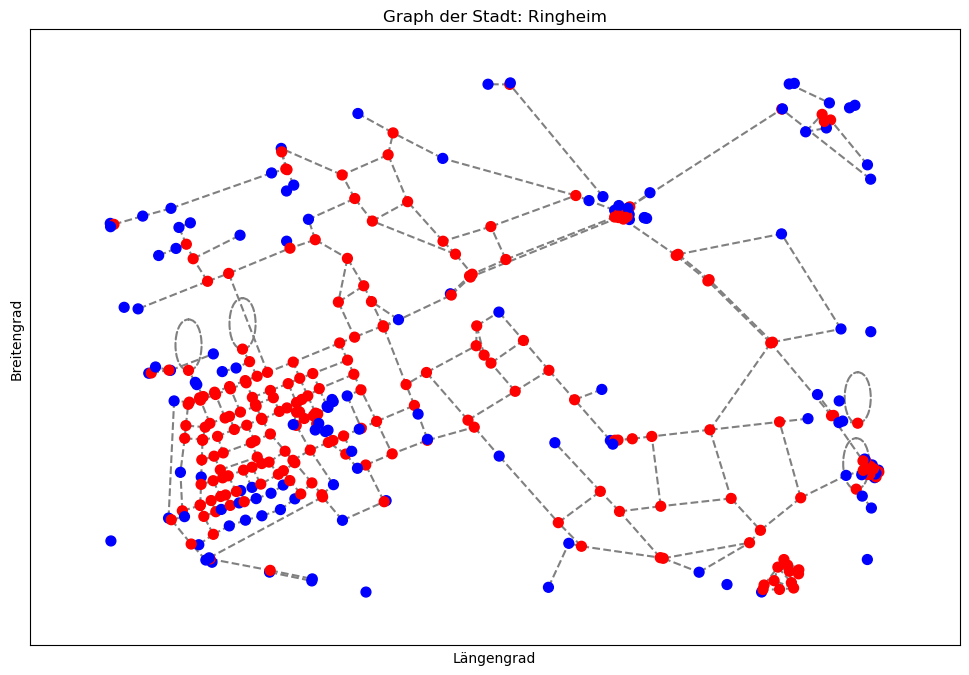

In [16]:
def load_city_data_json(city_name, input_folder="City_data"):
    filename = f"{city_name}.json"
    input_file = os.path.join(input_folder, filename)
    
    if not os.path.exists(input_file):
        print(f"Datei für {city_name} wurde nicht gefunden.")
        return None

    with open(input_file, 'r', encoding='utf-8') as f:
        return json.load(f)

def create_graph_from_city_data(city_name, input_folder="City_data"):
    filtered_data = load_city_data_json(city_name, input_folder)
    if filtered_data is None:
        return None

    G = nx.Graph()

    # Knoten zum Graphen hinzufügen
    for node in filtered_data["nodes"]:
        if "latitude" in node and "longitude" in node:
            G.add_node(node['id'], pos=(node['longitude'], node['latitude']))

    # Kanten zum Graphen hinzufügen
    for way in filtered_data["ways"]:
        node_ids_list = way.get('node_ids', [])
        if node_ids_list:
            # Filtere nur die Knoten-IDs, die im Graphen vorhanden sind
            filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
            if len(filtered_node_ids_list) > 1:
                for i in range(len(filtered_node_ids_list) - 1):
                    # Bestimme, ob die Straße gestrichelt sein soll
                    is_dashed_highway = way.get('tags', {}).get('highway') not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                    G.add_edge(
                        filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                        street_name=way.get('tags', {}).get('highway', ''),
                        is_dashed_highway=is_dashed_highway
                    )

    return G

# Visualisierung des Graphen
def plot_graph(city_name, input_folder="City_data"):
    G = create_graph_from_city_data(city_name, input_folder)
    if G is None:
        return

    pos = nx.get_node_attributes(G, 'pos')

    plt.figure(figsize=(12, 8))

    # Normale Kanten zeichnen
    edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
    nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

    # Gestrichelte Kanten zeichnen
    edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
    nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

    node_degrees = dict(G.degree())
    node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

    plt.title(f"Graph der Stadt: {city_name}")
    plt.xlabel("Längengrad")
    plt.ylabel("Breitengrad")
    plt.show()

plot_graph(city_name)

### Haversine Formel für die Längenberechnung

In [17]:
def haversine(lon1, lat1, lon2, lat2):
    # Dezimalzahlen in Radianten umwandeln
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine Formel
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius der Erde in Kilometer
    return c * r * 1000

### Knoten zusammenfügen, die nah beieinander stehen

In [18]:
# Löschen der Knoten, die durch anderen ersetzt wurde
def remove_replaced_nodes(df_nodes, node_merge_dict):
    replaced_node_ids = set(node_merge_dict.keys()) - set(node_merge_dict.values())
    return df_nodes[~df_nodes['id'].isin(replaced_node_ids)]

# Aktualisiere node_ids
def update_node_ids_merged(node_ids, node_merge_dict):
    if node_ids is not None and isinstance(node_ids, list):
        updated_node_ids = [node_merge_dict.get(node_id, node_id) for node_id in node_ids]
        # Entferne doppelte Knoten, falls sie durch das Zusammenführen entstanden sind
        unique_node_ids = list(dict.fromkeys(updated_node_ids))
        return unique_node_ids
    return node_ids

# Zusammenfügen der Knoten, die nah beieinander stehen
def merge_within_distance(df_nodes, max_distance=10):
    merged_nodes = []
    node_merge_dict = {}
    seen = set()

    for i, node_1 in df_nodes.iterrows():
        for j, node_2 in df_nodes.iterrows():
            # Vergleich gleicher Knoten verhindern
            if node_1['id'] == node_2['id'] or node_1['id'] in seen or node_2['id'] in seen:
                continue

            lon1, lat1 = node_1['longitude'], node_1['latitude']
            lon2, lat2 = node_2['longitude'], node_2['latitude']

            distance = haversine(lon1, lat1, lon2, lat2)

            if distance < max_distance:
                merged_node = {
                    'id': node_1['id'],
                    'longitude': (lon1 + lon2) / 2,
                    'latitude': (lat1 + lat2) / 2
                }
                merged_nodes.append(merged_node)

                # Knoten als gesehen markiert
                seen.add(node_1['id'])
                seen.add(node_2['id'])

                node_merge_dict[node_2['id']] = node_1['id']

    return merged_nodes, node_merge_dict

def process_city_data(city_name):
    json_file_path = os.path.join('City_data', f'{city_name}.json')
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    nodes_data = data.get('nodes', [])
    ways_data = data.get('ways', [])

    df_nodes = pd.DataFrame(nodes_data)
    df_ways = pd.DataFrame(ways_data)

    merged_nodes, node_merge_dict = merge_within_distance(df_nodes)

    # Wege aktualisieren
    df_ways['node_ids'] = df_ways['node_ids'].apply(
        lambda x: update_node_ids_merged(x, node_merge_dict)
    )

    # Ehemalige Knoten entfernen
    df_nodes_updated = remove_replaced_nodes(df_nodes, node_merge_dict)

    # Zusammenführen der aktualisierten Knoten und Wege
    updated_nodes_data = df_nodes_updated.to_dict(orient="records")
    updated_ways_data = df_ways.to_dict(orient="records")

    # Aktualisierte Daten in die Datei zurückschreiben
    updated_data = {
        'nodes': updated_nodes_data,
        'ways': updated_ways_data
    }

    # Speichern der Datei
    with open(json_file_path, 'w') as file:
        json.dump(updated_data, file, indent=4)

    print(f"Die Daten für die Stadt {city_name} wurden erfolgreich aktualisiert und gespeichert.")

process_city_data(city_name)

Die Daten für die Stadt Ringheim wurden erfolgreich aktualisiert und gespeichert.


### Graph nach Zusammenfügen der Knoten die beieinander stehen

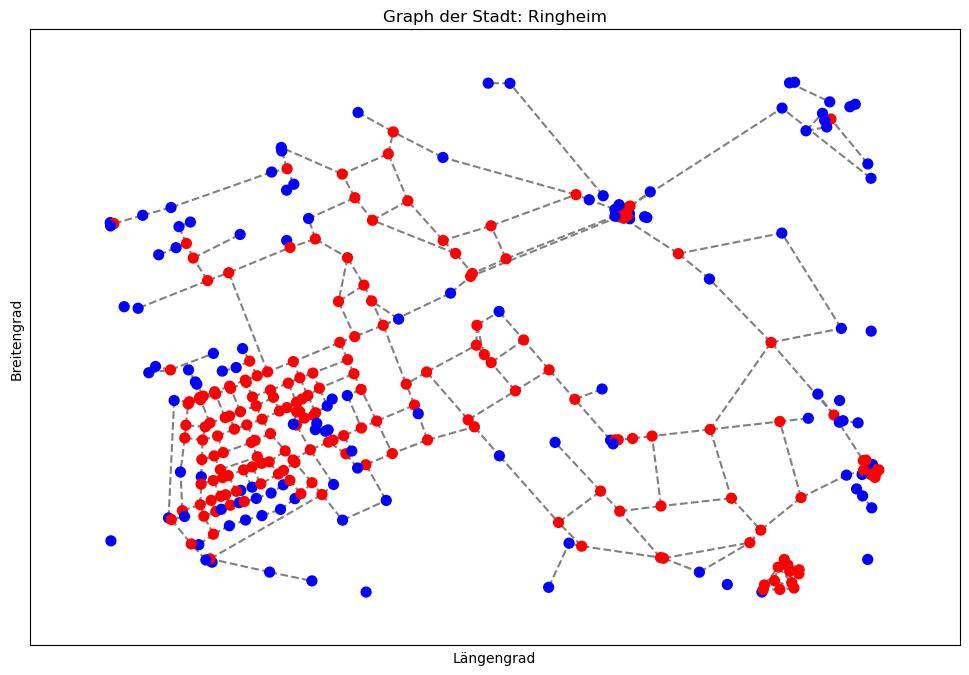

In [19]:
def load_city_data_json(city_name, input_folder="City_data"):
    filename = f"{city_name}.json"
    input_file = os.path.join(input_folder, filename)
    
    if not os.path.exists(input_file):
        print(f"Datei für {city_name} wurde nicht gefunden.")
        return None

    with open(input_file, 'r', encoding='utf-8') as f:
        return json.load(f)

def create_graph_from_city_data(city_name, input_folder="City_data"):
    filtered_data = load_city_data_json(city_name, input_folder)
    if filtered_data is None:
        return None

    G = nx.Graph()

    # Knoten zum Graphen hinzufügen
    for node in filtered_data["nodes"]:
        if "latitude" in node and "longitude" in node:
            G.add_node(node['id'], pos=(node['longitude'], node['latitude']))

    # Kanten zum Graphen hinzufügen
    for way in filtered_data["ways"]:
        node_ids_list = way.get('node_ids', [])
        if node_ids_list:
            # Filtere nur die Knoten-IDs, die im Graphen vorhanden sind
            filtered_node_ids_list = [node_id for node_id in node_ids_list if G.has_node(node_id)]
            if len(filtered_node_ids_list) > 1:
                for i in range(len(filtered_node_ids_list) - 1):
                    # Bestimme, ob die Straße gestrichelt sein soll
                    is_dashed_highway = way.get('tags', {}).get('highway') not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']
                    G.add_edge(
                        filtered_node_ids_list[i], filtered_node_ids_list[i + 1],
                        street_name=way.get('tags', {}).get('highway', ''),
                        is_dashed_highway=is_dashed_highway
                    )

    return G

# Visualisierung des Graphen
def plot_graph(city_name, input_folder="City_data"):
    G = create_graph_from_city_data(city_name, input_folder)
    if G is None:
        return

    pos = nx.get_node_attributes(G, 'pos')

    plt.figure(figsize=(12, 8))

    # Normale Kanten zeichnen
    edges_normal = [(u, v) for u, v, d in G.edges(data=True) if not d.get('is_dashed_highway')]
    nx.draw_networkx_edges(G, pos, edgelist=edges_normal, edge_color='gray', width=1.5)

    # Gestrichelte Kanten zeichnen
    edges_dashed = [(u, v) for u, v, d in G.edges(data=True) if d.get('is_dashed_highway')]
    nx.draw_networkx_edges(G, pos, edgelist=edges_dashed, edge_color='gray', width=1.5, style='--')

    node_degrees = dict(G.degree())
    node_color = ['red' if node_degrees[node] >= 3 else 'blue' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color)

    plt.title(f"Graph der Stadt: {city_name}")
    plt.xlabel("Längengrad")
    plt.ylabel("Breitengrad")
    plt.show()

plot_graph(city_name)

In [ ]:
node_degrees = dict(G.degree()) 

node_x = []
node_y = []
node_text = []  
node_color = [] 

for index, row in filtered_data_multiple.iterrows():
    if pd.notnull(row['longitude']) and pd.notnull(row['latitude']):
        node_x.append(row['longitude'])
        node_y.append(row['latitude'])
        
        hover_info = f"ID: {row['id']}<br>Tag Key: {row['tagkey']}<br>Tag Value: {row['tagvalue']}<br>Degree: {node_degrees[row['id']]}"
        node_text.append(hover_info)
        
        node_color.append(node_degrees[row['id']])

edge_x = []
edge_y = []
dashed_edge_x = []
dashed_edge_y = []
edge_street_names = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]

    # Überprüfen, ob der Rand highway != 'residual' ist
    is_dashed_highway = False
    street_name = ""
    for street in ways_filter.itertuples():
        if edge[0] in street.node_ids and edge[1] in street.node_ids:
            street_name = street.tagvalue
            # Highway-Kanten, die nicht 'residual' sind, werden gestrichelt
            if street.tagkey == "highway" and street.tagvalue not in ['residential', 'unclassified', 'service', 'tertiary', 'secondary']:
                is_dashed_highway = True
            break

    if is_dashed_highway:
        dashed_edge_x.extend([x0, x1, None])
        dashed_edge_y.extend([y0, y1, None])
    else:
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Berechnung der Mittelpunkte für die Straßennamen
    midpoint_x = (x0 + x1) / 2
    midpoint_y = (y0 + y1) / 2
    edge_street_names.append((midpoint_x, midpoint_y, street_name))


# Plot für durchgezogene Kanten
solid_edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# Plot für gestrichelte Kanten (highways)
dashed_edge_trace = go.Scatter(
    x=dashed_edge_x, y=dashed_edge_y,
    line=dict(width=0.5, color='#888', dash='dash'),
    hoverinfo='none',
    mode='lines'
)

# Plot für Knoten
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Knoten Verbindungen',
            xanchor='left',
            titleside='right'
        )),
    text=node_text
)

# Hinzufügen der Straßennamen zwischen den Knoten
street_name_trace = go.Scatter(
    x=[name[0] for name in edge_street_names],
    y=[name[1] for name in edge_street_names],
    text=[name[2] for name in edge_street_names],
    mode='text',
    textfont=dict(
        size=12,
        color='darkblue'
    ),
    hoverinfo='text'
)

layout = go.Layout(
    title=city_name,
    titlefont=dict(size=16),
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=0),
    annotations=[dict(
        text=title,
        showarrow=False,
        xref="paper", yref="paper",
        x=0.005, y=-0.002)],
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False)
)

fig = go.Figure(data=[solid_edge_trace, dashed_edge_trace, node_trace], layout=layout)

fig.show()

### Straßenlänge berechnen und im Diagramm darstellen

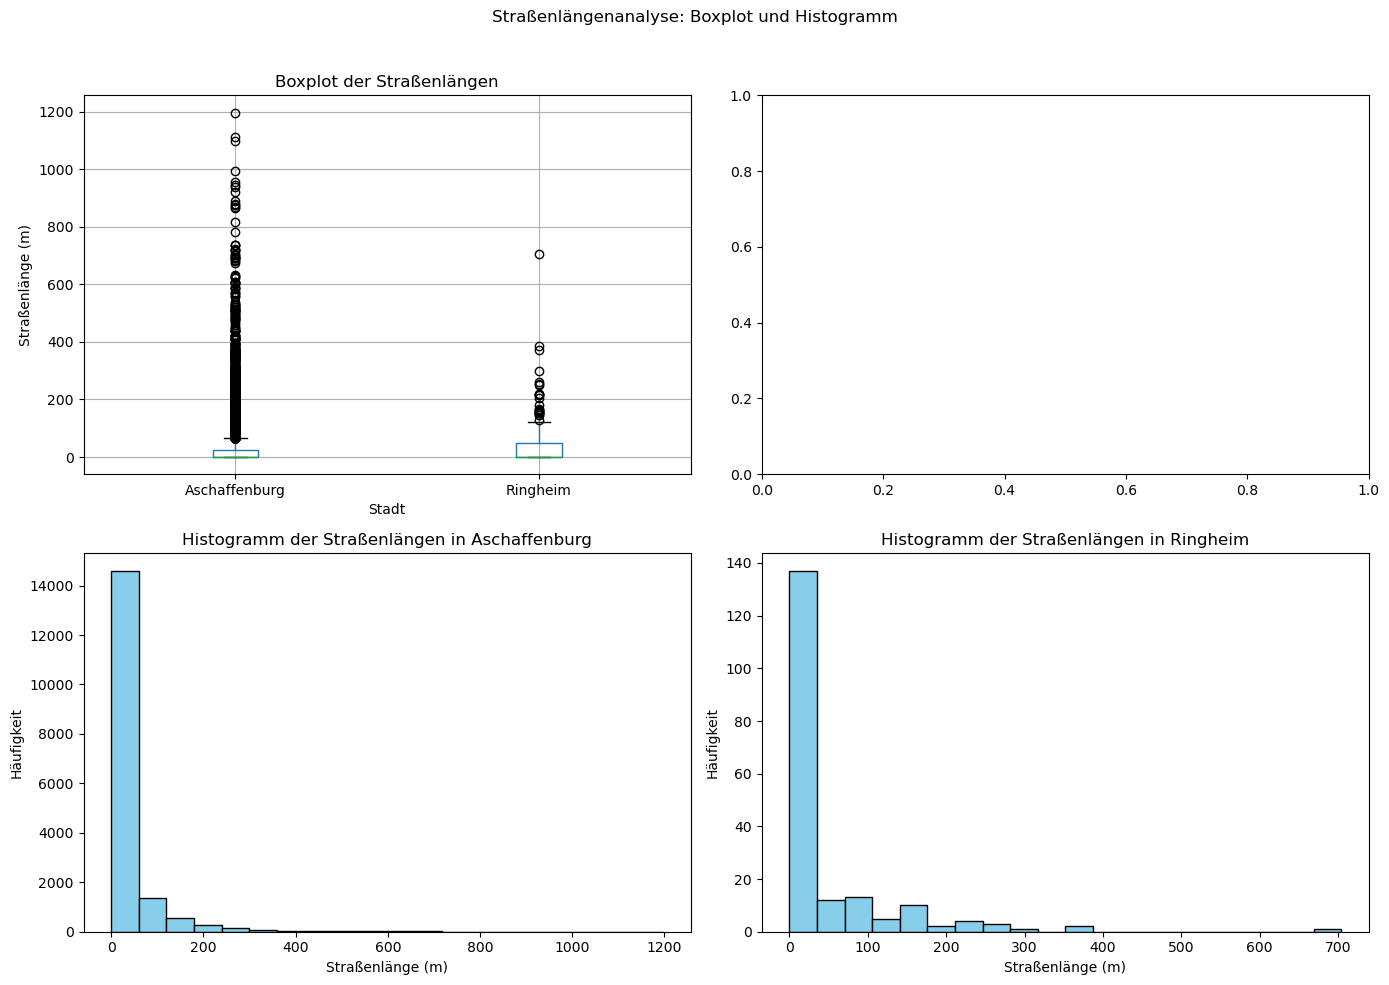

In [20]:
# Funktion zur Berechnung der Straßlänge
def calculate_full_road_length(way_row, df_nodes):
    node_ids = way_row['node_ids']
    total_length = 0

    for i in range(len(node_ids) - 1):
        first_node = df_nodes[df_nodes['id'] == node_ids[i]]
        second_node = df_nodes[df_nodes['id'] == node_ids[i + 1]]

        if first_node.empty or second_node.empty:
            return None

        total_length += haversine(
            first_node['longitude'].values[0], first_node['latitude'].values[0],
            second_node['longitude'].values[0], second_node['latitude'].values[0]
        )

    return total_length

# Funktion zur Verarbeitung der JSON-Dateien
def process_city_file(json_file_path, city_name):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    nodes_data = pd.DataFrame(data['nodes'])
    ways_data = pd.DataFrame(data['ways'])

    road_lengths = []

    for _, way_row in ways_data.iterrows():
        length = calculate_full_road_length(way_row, nodes_data)
        if length is not None:
            road_lengths.append({'city': city_name, 'way_id': way_row['id'], 'length': length})

    return pd.DataFrame(road_lengths)

# Dateien verarbeiten
aschaffenburg_file = "City_data/Aschaffenburg.json"
ringheim_file = "City_data/Ringheim.json"

df_aschaffenburg = process_city_file(aschaffenburg_file, "Aschaffenburg")
df_ringheim = process_city_file(ringheim_file, "Ringheim")

# Daten zusammenführen
df_combined = pd.concat([df_aschaffenburg, df_ringheim], ignore_index=True)

# Diagramme erstellen
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Boxplots
df_combined.boxplot(column='length', by='city', ax=axes[0, 0])
axes[0, 0].set_title("Boxplot der Straßenlängen")
axes[0, 0].set_xlabel("Stadt")
axes[0, 0].set_ylabel("Straßenlänge (m)")

# Histogramme
cities = ["Aschaffenburg", "Ringheim"]
for ax, city in zip(axes[1, :], cities):
    df_city = df_combined[df_combined['city'] == city]
    ax.hist(df_city['length'], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f"Histogramm der Straßenlängen in {city}")
    ax.set_xlabel("Straßenlänge (m)")
    ax.set_ylabel("Häufigkeit")

# Gesamttitel und Layout
plt.suptitle("Straßenlängenanalyse: Boxplot und Histogramm")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Diagramm um den Grad der Knoten

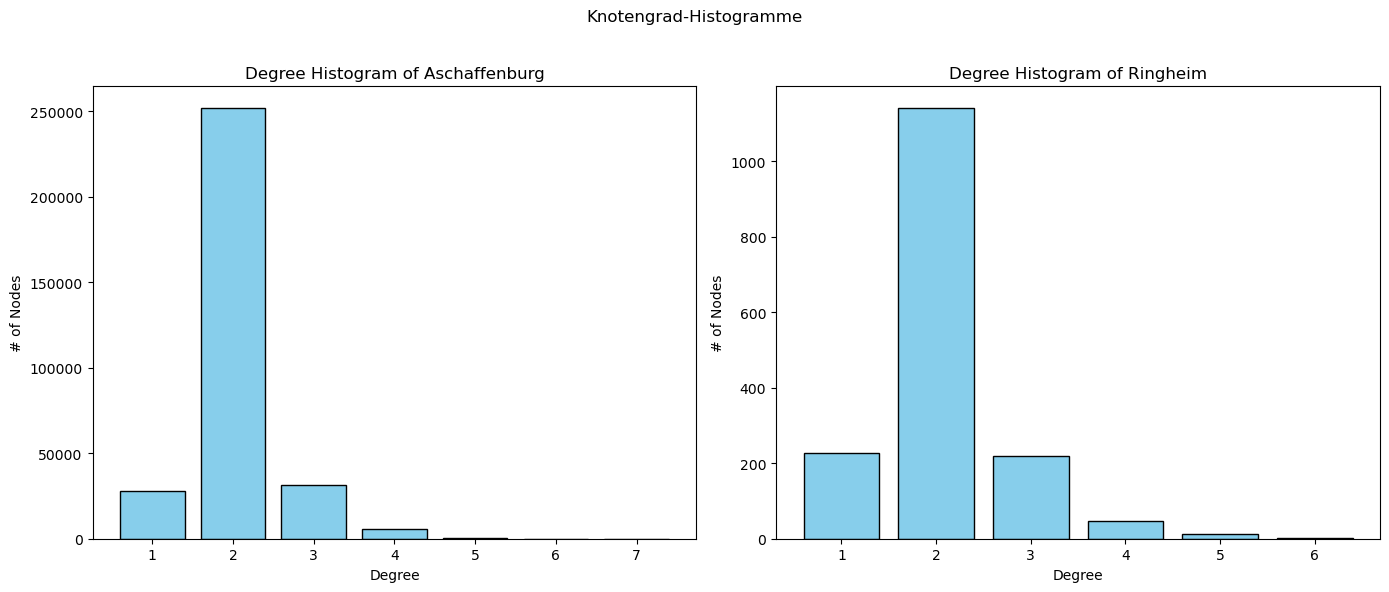

In [21]:
def create_graph_from_ways(ways_data):
    G = nx.Graph()
    for _, way_row in ways_data.iterrows():
        node_ids = way_row['node_ids']
        if isinstance(node_ids, list) and len(node_ids) > 1:
            edges = [(node_ids[i], node_ids[i+1]) for i in range(len(node_ids) - 1)]
            G.add_edges_from(edges)
    return G

def process_city_file_for_degree(json_file_path, city_name):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    ways_data = pd.DataFrame(data['ways'])
    return ways_data   

def plot_degree_histogram(node_degrees, city_name, ax):
    degrees = list(node_degrees.values())
    unique_degrees, counts = np.unique(degrees, return_counts=True)

    ax.bar(unique_degrees, counts, color='skyblue', edgecolor='black')
    ax.set_title(f"Degree Histogram of {city_name}")
    ax.set_xlabel("Degree")
    ax.set_ylabel("# of Nodes")
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

aschaffenburg_file = "City_data/Aschaffenburg.json"
ringheim_file = "City_data/Ringheim.json"

df_aschaffenburg = process_city_file_for_degree(aschaffenburg_file, "Aschaffenburg")
df_ringheim = process_city_file_for_degree(ringheim_file, "Ringheim")

G_aschaffenburg = create_graph_from_ways(df_aschaffenburg)
G_ringheim = create_graph_from_ways(df_ringheim)

node_degrees_aschaffenburg = dict(G_aschaffenburg.degree())
node_degrees_ringheim = dict(G_ringheim.degree())

# Histogramme erstellen
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_degree_histogram(node_degrees_aschaffenburg, "Aschaffenburg", axes[0])
plot_degree_histogram(node_degrees_ringheim, "Ringheim", axes[1])

plt.suptitle("Knotengrad-Histogramme")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()